<a href="https://colab.research.google.com/github/CurtisTelvanni/Live-American-Sign-Language-Recognition-EEE-312-Project/blob/main/ASL_live_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Install some dependencies for the code
They will not be installed on the local system.

In [ ]:
# import dependencies

!pip install mediapipe opencv-python
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.io import loadmat
from scipy.io import savemat
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from tensorflow.keras import datasets, layers, models

import numpy as np
import tensorflow as tf
import keras as keras
import matplotlib.pyplot as plt
import mediapipe as mp

import cv2
import PIL
import io
import html
import time
import h5py
import uuid
import os

# Provide Access to Google Drive
To load the cnn model saved on the cloud.
Login to your Google Account and Copy Paste the generated code in the box below


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Loading the Saved Model

In [ ]:
downloaded = drive.CreateFile({'id':'180DsRQIDpGx9W2vfg5jfC15FmdmLGeO7'})
downloaded.GetContentFile('model_final_2.index')
downloaded = drive.CreateFile({'id':'1-5KIkGPYhGq86y0SnoVATKMmSeC8UaW3'})
downloaded.GetContentFile('model_final_2.data-00000-of-00001') 
downloaded = drive.CreateFile({'id':'1-8UnH-39OpMjSP1qD2x_2ClfsQ4jWIoM'})
downloaded.GetContentFile('checkpoint') 

# Defining and Building the Model

In [ ]:
model = tf.keras.models.Sequential()

#model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(tf.keras.layers.Flatten(input_shape = [100, 100]))
#global max pooling
#data loader
#model.add(tf.keras.layers.Dense(128, activation = tf.nn.sigmoid))
model.add(tf.keras.layers.Dense(264, activation = tf.nn.sigmoid))
model.add(tf.keras.layers.Dense(39, activation = tf.nn.softmax))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)         

# Loading the Pretrained Model Parameters

In [ ]:
#calculated_out = (model.predict(test_in))
#print(calculated_out.shape)
model.load_weights('model_final_2')

# Setting Up Your Device's Camera (part 1)
Code provided by Google Colab

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# Setting Up Your Device's Camera (part 2)
Code provided by Google Colab

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# Live Video Stream
The detected sign language gestured by the person in the frame will be shown in the top left corner.

For best results and tracking,

1. Use the program in a well-lit area.
2. Keep the camera centered on the target person.
3. Keep the camera steady.
4. A Blank Background is preferable.
5. Once done, click/tap on the video stream to stop the program.
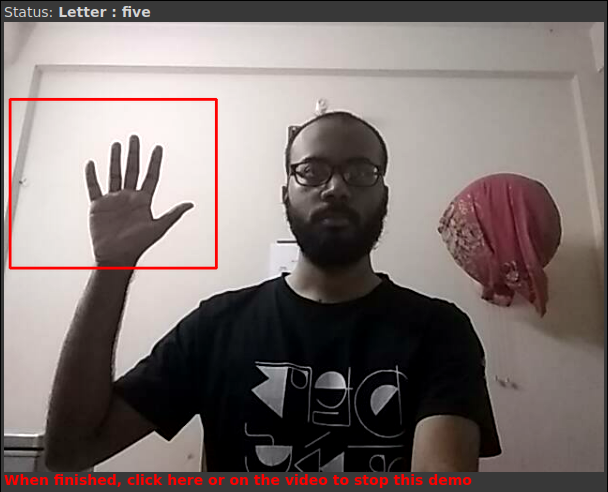


In [ ]:
#HAND TRACKER
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
#count = 0
state = 0

with mp_hands.Hands(min_detection_confidence=0.25, min_tracking_confidence=0.25) as hands:
  while True:
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      # convert JS response to OpenCV Image
      img = js_to_image(js_reply["img"])

      # create transparent overlay for bounding box
      bbox_array = np.zeros([480,640,4], dtype=np.uint8)
      
      image = img

      #HAND TRACKER
      # Set flag
      image.flags.writeable = False 
      # Detections
      results = hands.process(image) 
      # Set flag to true
      image.flags.writeable = True
      # Detections
      if not results.multi_hand_landmarks:
        x = 0
        y = 0
        hand_img = img[0:200, 0:200, :]
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+1,y+1),(0,0,0),0)
      else:
        hands_matrix = np.array_str(np.asarray(results.multi_hand_landmarks))
        x_pos = hands_matrix.find('x')
        y_pos = hands_matrix.find('y')
        x = round((int(hands_matrix[x_pos+5:x_pos+10])/100000)*640)
        y = round((int(hands_matrix[y_pos+5:y_pos+10])/100000)*480)
        if x>110 and y>150:
          #hand_img = img[y-150:y+30, x-90:x+90, :]
          hand_img = img[y-150:y+30, x-110:x+110, :]
          #bbox_array = cv2.rectangle(bbox_array,(x-90,y-150),(x+90,y+30),(255,0,0),2)
          bbox_array = cv2.rectangle(bbox_array,(x-110,y-150),(x+110,y+30),(255,0,0),2)
        else:
          hand_img = img[0:200, 0:200, :]
          bbox_array = cv2.rectangle(bbox_array,(x,y),(x+1,y+1),(0,0,0),0)
        
        #print(x)
        #print(y)
 
      size = (100, 100)
      imgre = cv2.resize(img, size)
      hand_imgre = cv2.resize(hand_img, size)

      bw = hand_imgre;
      bw_body = imgre
      #print(bw.shape)
      #plt.subplot(121)
      #plt.imshow(bw_body)
      #plt.subplot(122)
      #plt.imshow(bw)
 
      pic_in = np.zeros((1,100,100,3))
      pic_in[0,:,:,:] = bw
      #print(pic_in.shape) 
      #res = 1
      res = (model.predict(pic_in))
      res = np.where(res > 0.35, 1, 0)
    
      #print(res)
    
      res = (np.where(res[0,:] == 1)[0])
      label_names = ['zero -- or O','one','two -- or V','three','four','five','six -- or W','seven','eight','nine','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O -- or zero','P','Q','R','S','T','U','V -- or two','W -- or six','X','Y','Z','del','blank','space']
 
      #print(res[0])
      #print(label_names[res[0]])
    
 
      if not res.any() or x < 110:
        label_html = ' Letter : '+ 'can not detect'
      else:
        label_html = ' Letter : '+str(label_names[res[0]])
      #label_html = 'alu'
      state = not(state)
 
      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes

<IPython.core.display.Javascript object>